Supervised, Polyphonic, Single Instrument, Synthesized

In [1]:
# Imports
import pretty_midi
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from data import generate_samples
import tensorflow as tf
import IPython.display as ipd

In [2]:
tempo = 120.0  # beats per min
input_length = 3.0  # seconds
sr = 22050  # sample rate for synthesis
hop_length = 512
note_velocity = 90
# C4 - 60
min_pitch = 50  
max_pitch = 70  
num_notes = int(input_length / 60.0 * tempo)
secs_per_beat = 60.0 / tempo
fs = sr / hop_length  # sampling frequency of columns; time between column samples is 1./fs seconds
C1 = 4
C8 = 88
steps_per_song = sr / hop_length * input_length
secs_per_step = 1.0 / fs
window_size = 1  # additional frame length added to either side
max_polyphony = 4  # max notes played at once
p_polyphony = [0.15, 0.35, 0.25, 0.15, 0.1]
assert(steps_per_song / 2 > window_size)

In [3]:
# generate midi
piano_midi = pretty_midi.PrettyMIDI(initial_tempo=tempo)
piano_instr = pretty_midi.Instrument(1)

for i in range(num_notes):
    note_start = i * secs_per_beat
    note_end = (i+1) * secs_per_beat
    polyphony = np.random.choice(max_polyphony+1, p=p_polyphony)
    note_pitches = min_pitch + np.random.choice(max_pitch-min_pitch+1, size=polyphony, replace=False)
    for note_pitch in note_pitches:
        note = pretty_midi.Note(note_velocity, note_pitch, note_start, note_end)
        piano_instr.notes.append(note)
piano_midi.instruments.append(piano_instr)

In [4]:
# generate audio
piano_audio = piano_midi.fluidsynth(fs=sr)[:int(sr*input_length)]
print(len(piano_audio))
ipd.Audio(piano_audio, rate=sr)

66150


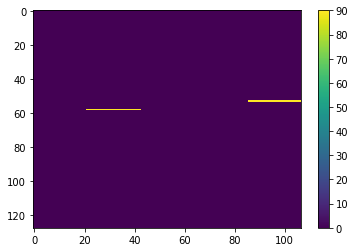

In [5]:
piano_roll = piano_midi.get_piano_roll(fs=fs)
plt.imshow(piano_roll, aspect='auto')
plt.colorbar()

C shape: (84, 129)


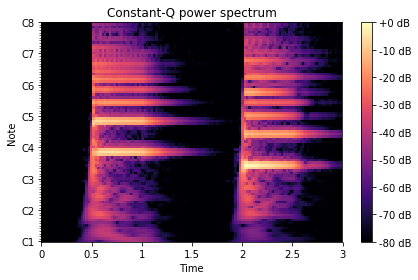

In [6]:
# get spectrogram from audio (training input)
C = np.abs(librosa.cqt(piano_audio, sr=sr, hop_length=hop_length, n_bins=84))
C = C[:, :-1]  # fix off by 1 error
print("C shape: {}".format(C.shape))
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                         sr=sr, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

C = np.transpose(C)

In [7]:
# generate data
x_train, y_train = generate_samples(100000, 100, phonic='poly')
x_test, y_test = generate_samples(10000, 10, phonic='poly')

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

generating songs...
done generating songs
(100, 129, 84)
(100, 129, 84)
generating songs...
done generating songs
(10, 129, 84)
(10, 129, 84)
(100000, 3, 84)
(100000, 84)
(10000, 3, 84)
(10000, 84)


In [8]:
# construct and train model
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(84, activation=tf.nn.sigmoid)
])
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

Epoch 1/5
100000/100000 [==============================] - 7s 71us/step - loss: 0.0064 - acc: 0.4414
Epoch 2/5
100000/100000 [==============================] - 7s 69us/step - loss: 0.0037 - acc: 0.4559
Epoch 3/5
100000/100000 [==============================] - 7s 72us/step - loss: 0.0033 - acc: 0.4663
Epoch 4/5
100000/100000 [==============================] - 7s 69us/step - loss: 0.0030 - acc: 0.4732
Epoch 5/5
100000/100000 [==============================] - 7s 70us/step - loss: 0.0028 - acc: 0.4806


In [9]:
# evaluate model
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 0s 24us/step


[0.006185233804490417, 0.516]

In [10]:
reconstructed_midi = pretty_midi.PrettyMIDI()
piano_instr = pretty_midi.Instrument(1)

print("new C {}".format(C.shape))
print(steps_per_song)
prev_pitch = -1
note_start = 0
for i in range(int(steps_per_song)):
    if i - window_size < 0 or i + window_size + 1 >= steps_per_song:
        continue
    my_input = np.expand_dims(C[i-window_size:i+window_size+1, :], 0)
    note_pitch = C1 + np.argmax(model.predict(my_input))
    if prev_pitch == -1:
        prev_pitch = note_pitch
    note_velocity = 90
    if prev_pitch != note_pitch:
        note_end = i * secs_per_step
        note = pretty_midi.Note(note_velocity, note_pitch, note_start, note_end)
        piano_instr.notes.append(note)
        note_start = i * secs_per_step
        prev_pitch = note_pitch
reconstructed_midi.instruments.append(piano_instr)

new C (129, 84)
129.19921875


In [11]:
# generate audio
reconstructed_audio = reconstructed_midi.fluidsynth(fs=sr)
print(len(reconstructed_audio))
ipd.Audio(reconstructed_audio, rate=sr)

84002
